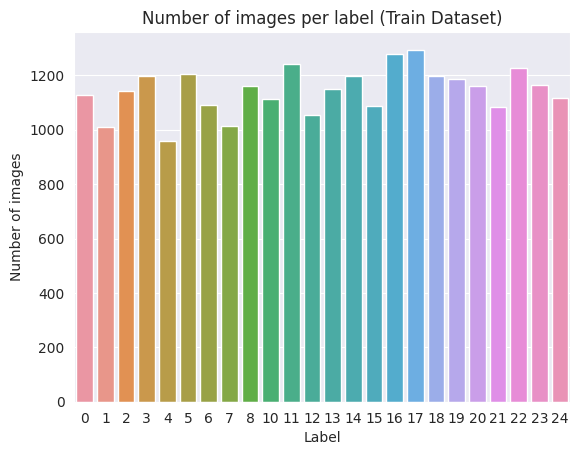

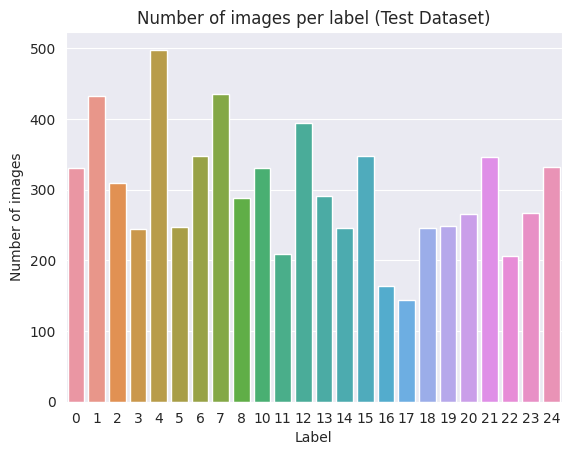

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_30 (Ba  (None, 28, 28, 75)        300       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 14, 14, 75)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_31 (Ba  (None, 14, 14, 50)      

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

# Loading the ASL dataset
train_df = pd.read_csv("/content/sign_mnist_train.csv")
test_df = pd.read_csv("/content/sign_mnist_test.csv")

test = pd.read_csv("/content/sign_mnist_test.csv")
y = test['label']

# Data Visualization and Preprocessing (train)
plt.figure()
sns.set_style("darkgrid")
sns.countplot(x='label', data=train_df)
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Number of images per label (Train Dataset)')
plt.show()

# Data Visualization and Preprocessing (test)
plt.figure()
sns.set_style("darkgrid")
sns.countplot(x='label', data=test_df)
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Number of images per label (Test Dataset)')
plt.show()

y_train = train_df['label']
y_test = test_df['label']
del train_df['label'] # Remove "label" column from dataset.
del test_df['label']

# One-Hot Encoding. Encode Labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# Convert DataFrames to NumPy arrays.
x_train = train_df.values
x_test = test_df.values

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# Preview of first 10 images of the Train Dataset.
f, ax = plt.subplots(2,5) # Figure with 2 rows and 5 columns
f.set_size_inches(10, 10) # Size of the figure
k = 0
for i in range(2): #
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray") #Show image in current sunbplot as gray-scale image.
        k += 1 # Increase index to obtain next image from DataSet.
    plt.tight_layout() # Adjust figure automatically so all the images fit properly.

# Data Augmentation to avoid overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


## Training The Model ##

# Callback "ReduceLROnPlateau". Adjust learning rate dynamically. patience = 2 means that after 2 epochs without improving precision, LR is reduced by half.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# Create sequential model. Groups a linear stack of layers.
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax')) # Activation function softmax because it is a multiclass classification problem. (24 labels)
# Compile with "Adam" optimizer and loss function "categorical_crossentropy". Used in multiclass classification.
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary() # Show Summary of the Net (CNN)

# Train model.
# x_train = Images
# y_train = labels
# batch size = 128 images
# epochs = 20
# validation data = images (x_test) and labels (y_test) used to validate the model.
# callbacks: ReduceLROnPlateau defined previously. Reduces LR based on certain criteria.
# output: history object. Contains information on how everything changes each epoch
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

# Learning curves visualization. Precision and loss.
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Additional evaluation and visualization

probabilities = model.predict(x_test)
predictions = np.argmax(probabilities, axis=1)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1

classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

cm = confusion_matrix(y, predictions)

classes = ["Class " + str(i) for i in range(25)]

cm = pd.DataFrame(cm, index=classes[:-1], columns=classes[:-1])

plt.figure(figsize=(15, 15))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='')

# correct = np.nonzero(predictions == y)[0]
# i = 0
# for c in correct[:6]:
#     plt.subplot(3, 2, i + 1)
#     plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y[c]))
#     plt.tight_layout()
#     i += 1

# plt.show()